In [26]:
#Import Necesssary Libraries
import os
import pandas as pd
from datetime import datetime
from collections import Counter
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pysentiment2 as ps
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader lexicon')

[nltk_data] Downloading package punkt to C:\Users\Long Him
[nltk_data]     Lui\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Long Him
[nltk_data]     Lui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading vader lexicon: Package 'vader lexicon' not
[nltk_data]     found in index


False

In [27]:
#Define function to tokenize
def process_text(text):
    tokens = word_tokenize(text.lower())
    remove_punc = str.maketrans('','', string.punctuation + string.digits)
    filtered_tokens = [word.translate(remove_punc) for word in tokens if word.isalpha() and word not in stopwords.words('english')]
    filtered_tokens = [word for word in filtered_tokens if word]
    return filtered_tokens

In [28]:
#Define function to calculate tone
def calculate_tone(document, positive_words, negative_words):
    word_freq = Counter(process_text(document))
    positive_count = sum(word_freq[word] for word in positive_words if word in word_freq)
    negative_count = sum(word_freq[word] for word in negative_words if word in word_freq)
    tone = (positive_count - negative_count) / len(word_freq)
    return tone

In [29]:
# Function to get the score for a document using pysentiment2
def get_hiv4_score(text):
    hiv4 = ps.HIV4()
    tokens = hiv4.tokenize(text)
    return hiv4.get_score(tokens)

In [30]:
# Load LM list
lm_dictionary_path = "C:/Users/Long Him Lui/Desktop/Imperial/Macro Finance/Coursework/Coursework 2/Loughran-McDonald_MasterDictionary_1993-2021.csv"
lm_dictionary = pd.read_csv(lm_dictionary_path)

# Extract lists of positive and negative words
positive_words_lm = set(lm_dictionary[lm_dictionary['Positive'] != 0]['Word'].str.lower())
negative_words_lm = set(lm_dictionary[lm_dictionary['Negative'] != 0]['Word'].str.lower())

In [31]:
# Load FOMC documents and dates
fomc_documents = []
fomc_dates = []
path_to_fomc_docs = "C:/Users/Long Him Lui/Desktop/Imperial/Macro Finance/Coursework/Coursework 2/Text Files"
for file_name in os.listdir(path_to_fomc_docs):
    date_str = file_name.split('.')[0]
    date_obj = datetime.strptime(date_str, '%Y%m%d')
    fomc_dates.append(date_obj)
    with open(os.path.join(path_to_fomc_docs, file_name), 'r', encoding='ISO-8859-1') as file:
        fomc_documents.append(file.read())

In [32]:
# Sort the dates and start counter
fomc_dates.sort()
overall_word_freq = Counter()

# Process and count words in each document
for doc in fomc_documents:
    processed_text = process_text(doc)
    overall_word_freq.update(processed_text)
    
# Convert to DataFrame and find the most influential unigrams
df_word_freq = pd.DataFrame(overall_word_freq.items(), columns=['Word', 'Frequency'])
df_word_freq_sorted = df_word_freq.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
print(df_word_freq_sorted.head(10))


         Word  Frequency
0   committee        927
1   inflation        670
2    economic        497
3     federal        411
4        rate        390
5      market        357
6      policy        339
7  securities        308
8  conditions        302
9     percent        272


In [33]:
# Calculate tone, sort by date
tones_lm = [calculate_tone(doc, positive_words_lm, negative_words_lm) for doc in fomc_documents]
fomc_dates, tones_lm = zip(*sorted(zip(fomc_dates, tones_lm)))
df_tones = pd.DataFrame({'Date': fomc_dates, 'Tone': tones_lm})
df_tones

,Date,Tone
0,2008-01-22,-0.034483
1,2008-01-30,-0.016807
2,2008-03-11,0.008547
3,2008-03-18,-0.036496
4,2008-04-30,-0.021277
...,...,...
76,2017-07-26,0.015625
77,2017-09-20,0.000000
78,2017-11-01,0.000000
79,2017-12-13,0.011236


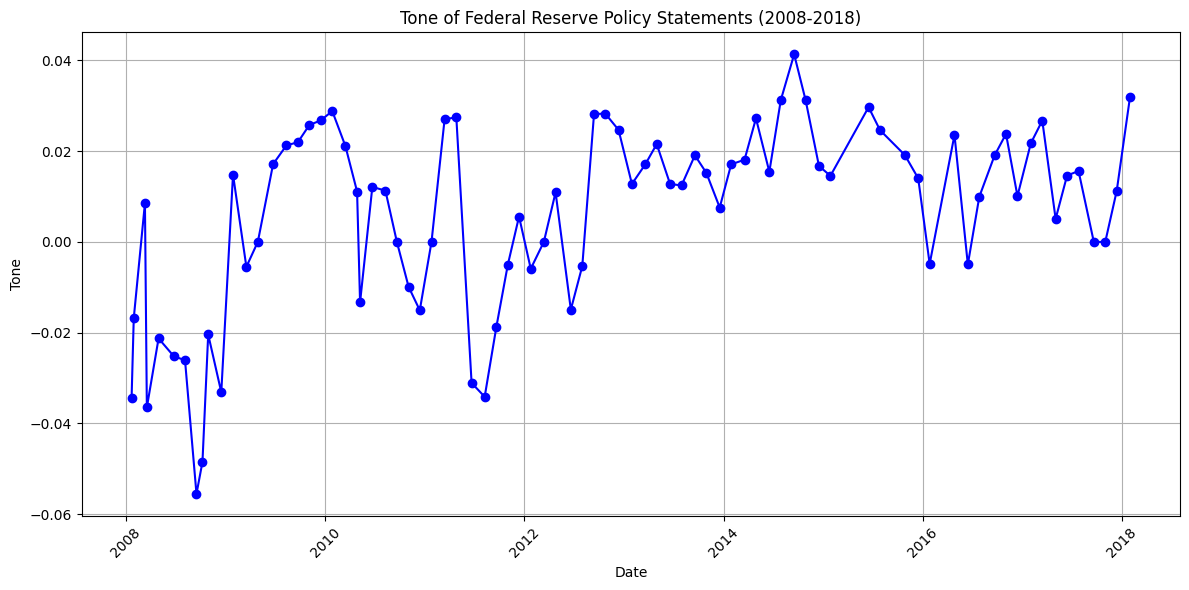

In [34]:
# Plotting tone of FOMC documents over time
plt.figure(figsize=(12, 6))
plt.plot(df_tones['Date'], df_tones['Tone'], marker='o', linestyle='-', color='blue')
plt.title('Tone of Federal Reserve Policy Statements (2008-2018)')
plt.xlabel('Date')
plt.ylabel('Tone')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# Convert to datetime and group by year
df_tones['Date'] = pd.to_datetime(df_tones['Date'])
df_tones['Year'] = df_tones['Date'].dt.year
average_tone_per_year = df_tones.groupby('Year')['Tone'].mean().reset_index()
print("Average Tone per Year:")
print(average_tone_per_year)

Average Tone per Year:
    Year      Tone
0   2008 -0.028128
1   2009  0.015289
2   2010  0.005137
3   2011 -0.003605
4   2012  0.008241
5   2013  0.014812
6   2014  0.024810
7   2015  0.020411
8   2016  0.010952
9   2017  0.011881
10  2018  0.032051


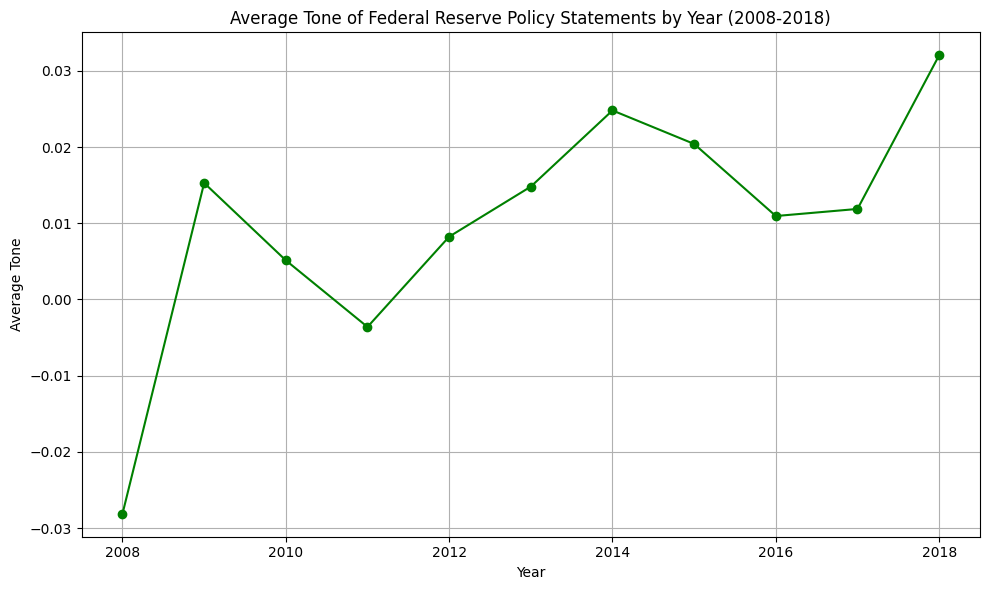

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(average_tone_per_year['Year'], average_tone_per_year['Tone'], marker='o', linestyle='-', color='green')
plt.title('Average Tone of Federal Reserve Policy Statements by Year (2008-2018)')
plt.xlabel('Year')
plt.ylabel('Average Tone')
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# Define function to couunt positive and negative words in LM
def count_lm_words(document, positive_words, negative_words):
    word_freq = Counter(process_text(document))
    positive_count = sum(word_freq[word] for word in positive_words if word in word_freq)
    negative_count = sum(word_freq[word] for word in negative_words if word in word_freq)
    return positive_count, negative_count

# Make counters for positive and negative words
lm_positive_counts = []
lm_negative_counts = []
harvard_positive_counts = []
harvard_negative_counts = []

# Loop for documents
for doc in fomc_documents:
    lm_pos_count, lm_neg_count = count_lm_words(doc, positive_words_lm, negative_words_lm)
    lm_positive_counts.append(lm_pos_count)
    lm_negative_counts.append(lm_neg_count)
    score = get_hiv4_score(doc)
    harvard_positive_counts.append(score['Positive'])
    harvard_negative_counts.append(score['Negative'])

# Create a DataFrame for comparison
df_comparison = pd.DataFrame({
    'Document Date': fomc_dates,
    'LM Positive': lm_positive_counts,
    'LM Negative': lm_negative_counts,
    'Harvard Positive': harvard_positive_counts,
    'Harvard Negative': harvard_negative_counts
})
print(df_comparison.head(81))

   Document Date  LM Positive  LM Negative  Harvard Positive  Harvard Negative
0     2008-01-22            0            4                19                 8
1     2008-01-30            0            2                19                 7
2     2008-03-11            1            0                25                 3
3     2008-03-18            1            6                26                13
4     2008-04-30            2            5                31                11
..           ...          ...          ...               ...               ...
76    2017-07-26            6            3                47                18
77    2017-09-20            7            7                48                24
78    2017-11-01            6            6                44                24
79    2017-12-13            6            4                40                22
80    2018-01-31            6            1                35                16

[81 rows x 5 columns]


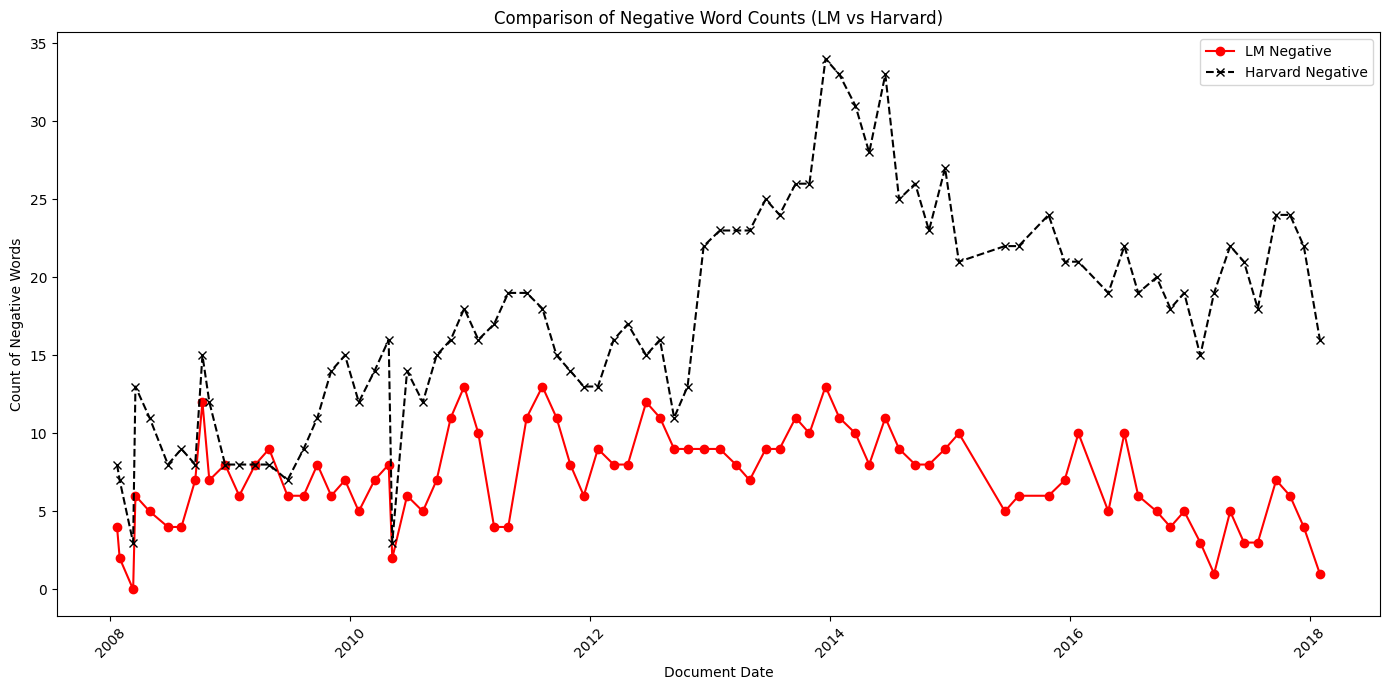

In [38]:
# Plotting Negative Word Counts from LM and Harvard
plt.figure(figsize=(14, 7))
plt.plot(df_comparison['Document Date'], df_comparison['LM Negative'], label='LM Negative', marker='o', linestyle='-', color='red')
plt.plot(df_comparison['Document Date'], df_comparison['Harvard Negative'], label='Harvard Negative', marker='x', linestyle='--', color='black')
plt.title('Comparison of Negative Word Counts (LM vs Harvard)')
plt.xlabel('Document Date')
plt.ylabel('Count of Negative Words')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

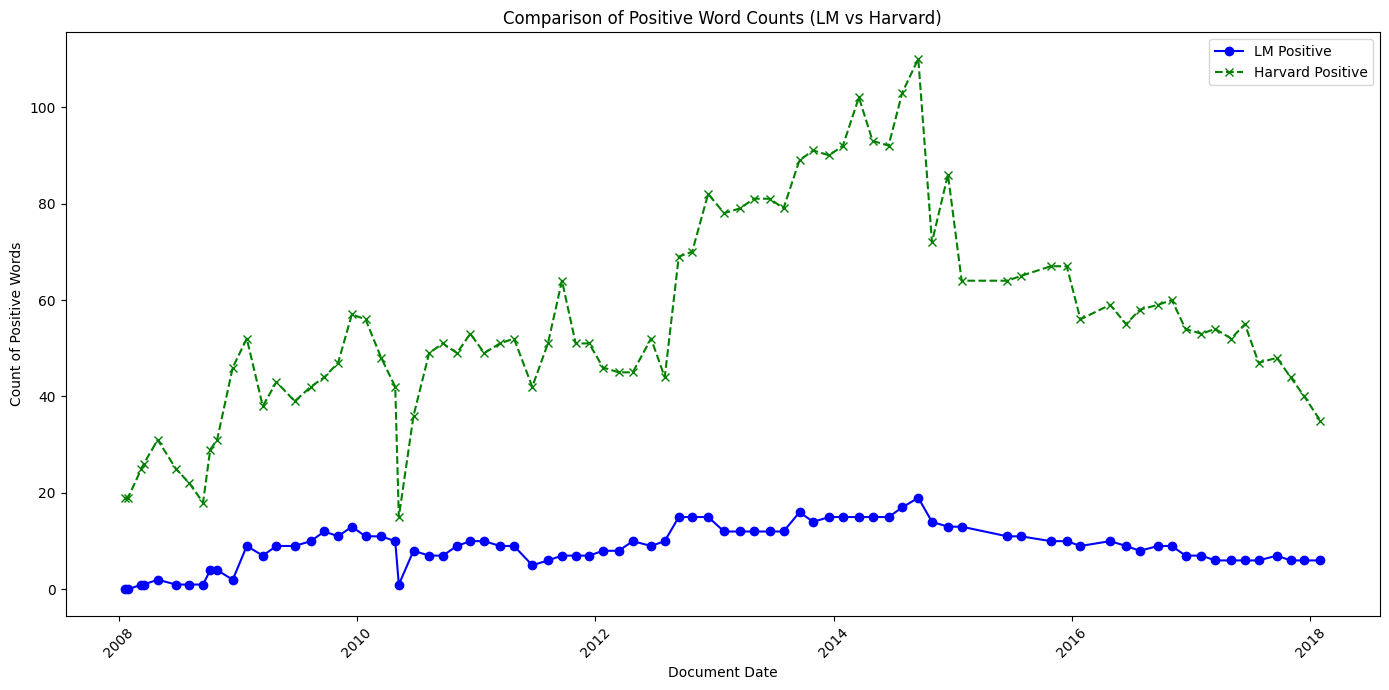

In [39]:
# Plotting Positive Word Counts from LM and Harvard
plt.figure(figsize=(14, 7))
plt.plot(df_comparison['Document Date'], df_comparison['LM Positive'], label='LM Positive', marker='o', linestyle='-', color='blue')
plt.plot(df_comparison['Document Date'], df_comparison['Harvard Positive'], label='Harvard Positive', marker='x', linestyle='--', color='green')
plt.title('Comparison of Positive Word Counts (LM vs Harvard)')
plt.xlabel('Document Date')
plt.ylabel('Count of Positive Words')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
# Load the LM word list
lm_dictionary = pd.read_csv(lm_dictionary_path)
positive_words_lm = set(lm_dictionary[lm_dictionary['Positive'] != 0]['Word'].str.lower())
negative_words_lm = set(lm_dictionary[lm_dictionary['Negative'] != 0]['Word'].str.lower())

def process_text(text):
    tokens = word_tokenize(text.lower())
    remove_punc = str.maketrans('', '', string.punctuation + string.digits)
    filtered_tokens = [word.translate(remove_punc) for word in tokens if word.isalpha()]
    filtered_tokens = [word for word in filtered_tokens if word not in stopwords.words('english')]
    return filtered_tokens

all_words_freq = Counter()

# Process each document in the folder and count all words
for file_name in os.listdir(path_to_fomc_docs):
    if file_name.endswith('.txt'):
        file_path = os.path.join(path_to_fomc_docs, file_name)
        with open(file_path, 'r', encoding='ISO-8859-1') as file:
            text = file.read()
            tokens = process_text(text)
            all_words_freq.update(tokens)

# Filter into positive/negative sets, sort frequencies
positive_word_freq = {word: freq for word, freq in all_words_freq.items() if word in positive_words_lm}
negative_word_freq = {word: freq for word, freq in all_words_freq.items() if word in negative_words_lm}

sorted_positive_words = sorted(positive_word_freq.items(), key=lambda item: item[1], reverse=True)
sorted_negative_words = sorted(negative_word_freq.items(), key=lambda item: item[1], reverse=True)

top_positive_words = sorted_positive_words[:10]
top_negative_words = sorted_negative_words[:10]

positive_word_freq = {word: freq for word, freq in overall_word_freq.items() if word in positive_words_lm}
negative_word_freq = {word: freq for word, freq in overall_word_freq.items() if word in negative_words_lm}

top_positive_words = pd.DataFrame(sorted(positive_word_freq.items(), key=lambda x: x[1], reverse=True)[:10], columns=['Word', 'Frequency'])
top_negative_words = pd.DataFrame(sorted(negative_word_freq.items(), key=lambda x: x[1], reverse=True)[:10], columns=['Word', 'Frequency'])

# Display the dataframes as tables
print("Top 10 Positive Words:")
print(top_positive_words.to_string(index=False))
print("\nTop 10 Negative Words:")
print(top_negative_words.to_string(index=False))

Top 10 Positive Words:
         Word  Frequency
    stability        162
  improvement         75
     progress         74
       stable         61
exceptionally         57
     stronger         39
     improved         37
   strengthen         33
        gains         22
  strengthens         21

Top 10 Negative Words:
        Word  Frequency
unemployment         97
    declines         36
    declined         32
     decline         26
        weak         25
      slowed         23
   depressed         22
    downward         21
        slow         19
     strains         17


In [41]:

harvard_scores = []

# Loop for documents
for doc in fomc_documents:
    score = get_hiv4_score(doc)
    harvard_scores.append(score)
for date, score in zip(fomc_dates, harvard_scores):
    print(f"Document Date: {date}, Score: {score}")

Document Date: 2008-01-22 00:00:00, Score: {'Positive': 19, 'Negative': 8, 'Polarity': 0.4074073923182447, 'Subjectivity': 0.20769230609467457}
Document Date: 2008-01-30 00:00:00, Score: {'Positive': 19, 'Negative': 7, 'Polarity': 0.4615384437869829, 'Subjectivity': 0.2096774176638918}
Document Date: 2008-03-11 00:00:00, Score: {'Positive': 25, 'Negative': 3, 'Polarity': 0.7857142576530622, 'Subjectivity': 0.16666666567460317}
Document Date: 2008-03-18 00:00:00, Score: {'Positive': 26, 'Negative': 13, 'Polarity': 0.33333332478632505, 'Subjectivity': 0.25490195911828784}
Document Date: 2008-04-30 00:00:00, Score: {'Positive': 31, 'Negative': 11, 'Polarity': 0.476190464852608, 'Subjectivity': 0.2658227831277039}
Document Date: 2008-06-25 00:00:00, Score: {'Positive': 25, 'Negative': 8, 'Polarity': 0.5151514995408637, 'Subjectivity': 0.24999999810606063}
Document Date: 2008-08-05 00:00:00, Score: {'Positive': 22, 'Negative': 9, 'Polarity': 0.4193548251821024, 'Subjectivity': 0.24031007565

C:\Users\Long Him Lui\AppData\Local\Temp\ipykernel_1860\2473201089.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(dates, polarity_scores, linestyle='solid', marker=None)


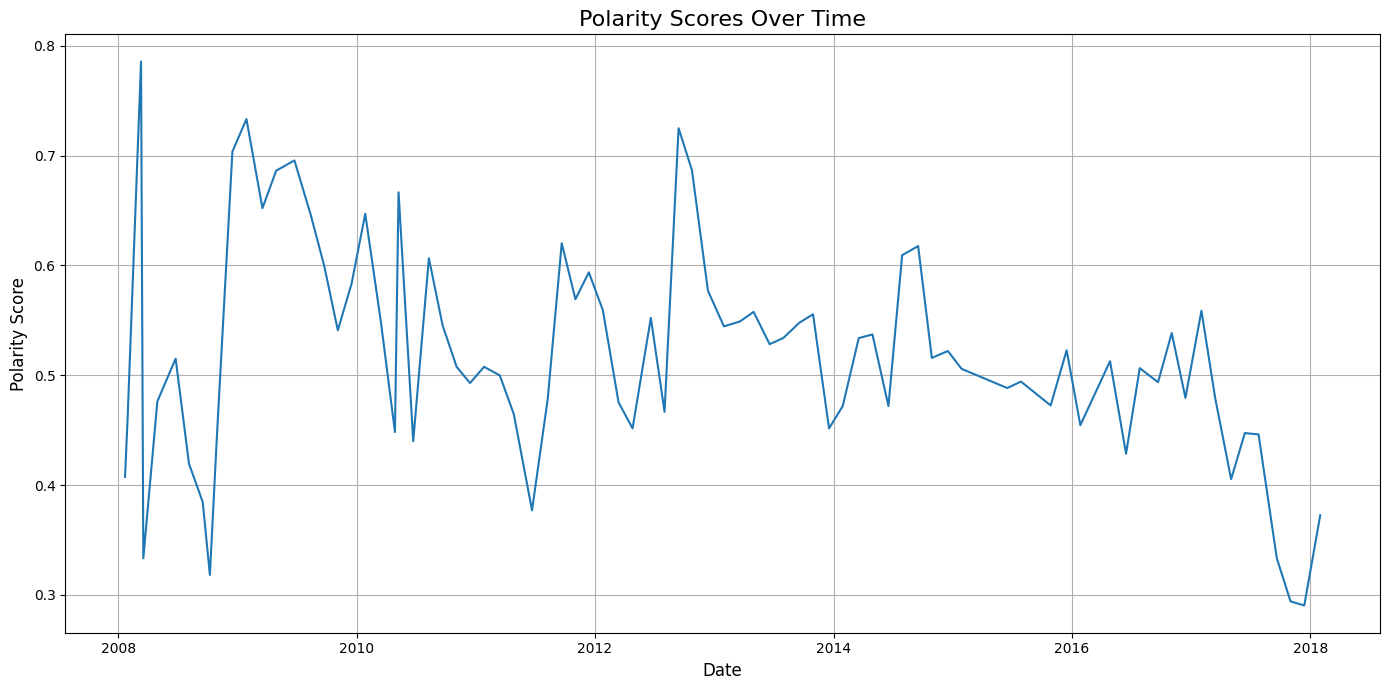

In [42]:
# Convert the dates into datetime
dates = [datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S') for date in fomc_dates]
fomc_scores = [get_hiv4_score(doc) for doc in fomc_documents]
polarity_scores = [score['Polarity'] for score in fomc_scores]


# Sort and plot
dates, polarity_scores = zip(*sorted(zip(dates, polarity_scores)))

plt.figure(figsize=(14, 7))
plt.plot_date(dates, polarity_scores, linestyle='solid', marker=None)
plt.title('Polarity Scores Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Polarity Score', fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()


In [43]:
all_words_freq = Counter()

# Process documents
for doc in fomc_documents:
    tokens = process_text(doc)
    all_words_freq.update(tokens)

harvard_sentiment_word_freq = Counter()

for doc in fomc_documents:
    tokens = process_text(doc)
    score = get_hiv4_score(doc)
    for token in tokens:
        if score['Polarity'] > 0:
            harvard_sentiment_word_freq[token] += score['Polarity']
        elif score['Polarity'] < 0:
            harvard_sentiment_word_freq[token] -= score['Polarity']

# But you can now sort this to get the words that have the highest and lowest scores
sorted_sentiment_words = sorted(harvard_sentiment_word_freq.items(), key=lambda item: item[1], reverse=True)
print(sorted_sentiment_words[:10]) 
print(sorted_sentiment_words[-10:]) 

[('committee', 481.3361646689946), ('inflation', 332.463684794037), ('economic', 257.0837907920783), ('federal', 216.76209110633886), ('rate', 195.98604032692157), ('market', 182.00389480204845), ('policy', 175.54170298332747), ('securities', 168.82103458357602), ('conditions', 155.67806501078402), ('labor', 135.3800697165015)]
[('pointing', 0.3181818109504134), ('request', 0.3181818109504134), ('caused', 0.2941176427335641), ('drop', 0.2941176427335641), ('payroll', 0.2941176427335641), ('boosting', 0.2941176427335641), ('initiated', 0.2941176427335641), ('averaging', 0.29032257596253913), ('affected', 0.29032257596253913), ('altered', 0.29032257596253913)]


In [45]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
positive_word_count = Counter()
negative_word_count = Counter()

# Loop for documents
for doc in fomc_documents:
    tokens = process_text(doc)
    for token in tokens:
        if len(token) > 1:  
            score = sia.polarity_scores(token)
            if score['compound'] > 0.1: 
                positive_word_count[token] += 1
            elif score['compound'] < -0.1: 
                negative_word_count[token] += 1

top_positive_words = positive_word_count.most_common(10)
top_negative_words = negative_word_count.most_common(10)

# Convert counts to DataFrames
df_top_positive_words = pd.DataFrame(top_positive_words, columns=['Word', 'Count'])
df_top_negative_words = pd.DataFrame(top_negative_words, columns=['Word', 'Count'])

print("Top Positive Words:")
print(df_top_positive_words)
print("\nTop Negative Words:")
print(df_top_negative_words)

[nltk_data] Downloading package vader_lexicon to C:\Users\Long Him
[nltk_data]     Lui\AppData\Roaming\nltk_data...


Top Positive Words:
          Word  Count
0   securities    308
1       growth    135
2      support     97
3     treasury     95
4         help     85
5       energy     76
6  improvement     75
7     progress     74
8        asset     68
9       stable     61

Top Negative Words:
           Word  Count
0           low    115
1  unemployment     97
2         risks     88
3          debt     61
4     pressures     59
5         lower     33
6      downside     30
7          weak     25
8     depressed     22
9      pressure     20


In [46]:
# LM
# Fetch S&P 500 data from 2008-2017
sp500 = yf.download('^GSPC', start='2008-01-01', end='2018-01-01')

# Calculate returns, format dates
sp500['Returns'] = sp500['Adj Close'].pct_change()
sp500_monthly_returns = sp500['Returns'].resample('M').agg(lambda x: (x + 1).prod() - 1)
sp500_monthly_returns = sp500_monthly_returns.reset_index()
df_tones['Date'] = pd.to_datetime(df_tones['Date'])
sp500_monthly_returns['Date'] = pd.to_datetime(sp500_monthly_returns['Date'])

# Merge data
merged_data = pd.merge_asof(df_tones.sort_values('Date'), sp500_monthly_returns.sort_values('Date'), on='Date', direction='nearest')
merged_data.dropna(subset=['Returns'], inplace=True)

# Regression analysis
X = sm.add_constant(merged_data['Tone'])
Y = merged_data['Returns']

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print(model.summary())

C:\Users\Long Him Lui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     8.149
Date:                Mon, 19 Feb 2024   Prob (F-statistic):            0.00550
Time:                        23:51:56   Log-Likelihood:                 139.25
No. Observations:                  81   AIC:                            -274.5
Df Residuals:                      79   BIC:                            -269.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.005      0.394      0.6


C:\Users\Long Him Lui\AppData\Local\Temp\ipykernel_1860\1596568579.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_monthly_returns = sp500['Returns'].resample('M').agg(lambda x: (x + 1).prod() - 1)


In [47]:
#HARVARD
# Define function to get the score for a document using pysentiment2
def get_hiv4_score(text):
    hiv4 = ps.HIV4()
    tokens = hiv4.tokenize(text)
    return hiv4.get_score(tokens)

# Load FOMC documents and their dates
fomc_documents = []
fomc_dates = []
path_to_fomc_docs = "C:/Users/Long Him Lui/Desktop/Imperial/Macro Finance/Coursework/Coursework 2/Text Files"
for file_name in os.listdir(path_to_fomc_docs):
    date_str = file_name.split('.')[0]
    date_obj = pd.to_datetime(date_str, format='%Y%m%d')
    fomc_dates.append(date_obj)
    with open(os.path.join(path_to_fomc_docs, file_name), 'r', encoding='ISO-8859-1') as file:
        fomc_documents.append(file.read())

fomc_scores = [get_hiv4_score(doc) for doc in fomc_documents]
harvard_polarity_scores = [score['Polarity'] for score in fomc_scores]

# Fetch S&P 500 data, calculate returns, format
sp500 = yf.download('^GSPC', start='2008-01-01', end='2018-01-01')
sp500['Returns'] = sp500['Adj Close'].pct_change()
sp500_monthly_returns = sp500['Returns'].resample('M').agg(lambda x: (x + 1).prod() - 1)
sp500_monthly_returns = sp500_monthly_returns.reset_index()
sp500_monthly_returns['Date'] = pd.to_datetime(sp500_monthly_returns['Date'])

# Align polarity with S&P 500 data
aligned_data_harvard = pd.DataFrame({
    'Date': fomc_dates,
    'Harvard_Polarity': harvard_polarity_scores
})

# Merge data
merged_data_harvard = pd.merge_asof(
    aligned_data_harvard.sort_values('Date'), 
    sp500_monthly_returns.sort_values('Date'), 
    on='Date', 
    direction='nearest'
)
merged_data_harvard.dropna(subset=['Returns'], inplace=True)

# Regression analysis
X_harvard = sm.add_constant(merged_data_harvard['Harvard_Polarity']) 
Y_harvard = merged_data_harvard['Returns']

model_harvard = sm.OLS(Y_harvard, X_harvard).fit()
print("Harvard Dictionary Polarity Regression Summary:")
print(model_harvard.summary())

C:\Users\Long Him Lui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Harvard Dictionary Polarity Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.876
Date:                Mon, 19 Feb 2024   Prob (F-statistic):              0.175
Time:                        23:52:56   Log-Likelihood:                 136.23
No. Observations:                  81   AIC:                            -268.5
Df Residuals:                      79   BIC:                            -263.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------


C:\Users\Long Him Lui\AppData\Local\Temp\ipykernel_1860\718480791.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_monthly_returns = sp500['Returns'].resample('M').agg(lambda x: (x + 1).prod() - 1)
